In [1]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

Meu nome é: Gabriel Moraes Barros 
Meu RA é: 192801


Refazer o exercício da week05, porém agora utilizando o PyTorch

Para quem estiver já habituado no uso do PyTorch este exercício pode ser trocado pelo:

1. Fazer o transfer learning do Cifar (exercício da week06
2. Fazer otimização para calcular uma imagem sintética com pixels otimizados para que a probabilidade de uma classe (à sua escolha) seja maximizada.

Tenho um exemplo ainda em desenvolvimento em https://t-adessowiki.fee.unicamp.br/user/lotufo/notebooks/lotufo/ia368z/deliver-pytorch/transfer_learning_tutorial.ipynb

que pode ser utilizado como inspiração. Estou procurando outros também.

## Importação das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pandas as pd

In [3]:
import time
import copy
import os
import sys
from copy import deepcopy

In [4]:
import torch as tc
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision import datasets, models, transforms


In [5]:
from torch.optim.lr_scheduler import StepLR
from PIL import Image
plt.ion()   # interactive mode


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F 
from torch import np
from torch.optim.lr_scheduler import StepLR
import torch.utils.data as data_utils
from PIL import Image


## Define a variável da GPU

In [7]:
use_gpu = tc.cuda.is_available()
print(use_gpu)

False


## Método de criar um dataset igual ao do Antonio ( a145349 )

In [32]:
class cifar_redux(tc.utils.data.Dataset):
    """CIFAR redux dataset with 3 classes."""
    def __init__(self, origin_file, train=False, transform=None):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.origin_file = origin_file
        self.transform = transform
        self.data = np.load(self.origin_file)
        if train:
            self.images = self.data['X_train']
            self.target = tc.from_numpy(self.data['y_train']).type(tc.LongTensor) - 3
        else:
            self.images = self.data['X_test']
            self.target = tc.from_numpy(self.data['y_test']).type(tc.LongTensor) - 3
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.target[idx]
        #print(type(image))
        #print('image shape',image.shape)
        image = Image.fromarray(np.uint8(image.reshape(3, 32, 32).transpose((1,2,0))), 'RGB')
        
        #print('type image after image',type(image))
        if self.transform:
            image = self.transform(image)

        return image, target

### Criando as transformações nos dados

In [33]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

no_transform = transforms.Compose([
    transforms.ToTensor()
])

### Fazendo as istâncias do dataset

In [34]:
!ls ..

cifar_redux_augmented_vgg.history   my_mapa_atributos2.ipynb  week04
cifar_redux_augmented_vgg.model     teste		      week05
italos				    Train_function	      week06
model1_model_weights.h5		    utils		      week07
models				    week02		      week08
my_cifar_dataplus_model_weights.h5  week03		      week09


In [35]:

cifar_redux_train = cifar_redux('/data/datasets/cifar10-redux.npz', train=True, 
                                transform=data_transforms['train'])

cifar_redux_test = cifar_redux('/data/datasets/cifar10-redux.npz', train=False, 
                                transform=data_transforms['test'])

cifar_redux_train = cifar_redux('../cifar10-redux.npz', train=True, 
                                transform=data_transforms['train'])

cifar_redux_test = cifar_redux('../cifar10-redux.npz', train=False, 
                                transform=data_transforms['test'])

In [36]:
cifar_redux_train_no_transform = cifar_redux('/data/datasets/cifar10-redux.npz', train=True,
                                             transform = no_transform)

## Comparação de imagens com transform e sem transform

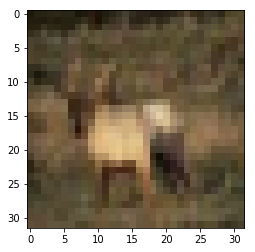

In [37]:
image_without_transf,label1 = cifar_redux_train_no_transform[0]
plt.figure()
plt.imshow(image_without_transf.numpy().transpose((1,2,0)))

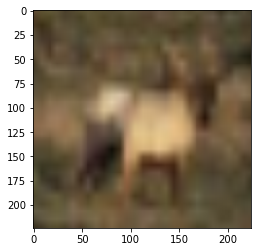

In [38]:
image_with_transf,label0 = cifar_redux_train[0]
plt.figure()
plt.imshow(image_with_transf.numpy().transpose((1,2,0)))

### Criando o dataloader

In [39]:
train_loader = tc.utils.data.DataLoader(cifar_redux_train, batch_size=4, shuffle=True, num_workers=2)
test_loader = tc.utils.data.DataLoader(cifar_redux_test, batch_size=10, shuffle=False, num_workers=2)

print('length of training dataloader', len(train_loader))
print('length of test dataloader', len(test_loader))

length of training dataloader 500
length of test dataloader 50


In [40]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


## Função para treinamento

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving (deep copying) the best model

In the following, parameter ``lr_scheduler(optimizer, epoch)``
is a function  which modifies ``optimizer`` so that the learning
rate is changed according to desired schedule.


In [41]:
def train_model(model,dset_loaders, dset_sizes,
                criterion, optimizer, lr_scheduler,
                num_epochs=25, model_fn=None, reset=False):
    
    since = time.time()

    if not reset and os.path.isfile(model_fn):
        #model.load_state_dict(tc.load(model_fn))
        print('Loading model %s' % model_fn)
        model = tc.load(model_fn)
    else:
        print('Build model from init')
    try:
        best_model = copy.deepcopy(model)
        best_epoch = 0
        best_acc = 0.0

        for epoch in range(num_epochs):
            start_epoch = time.time()
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    optimizer = lr_scheduler(optimizer, epoch)
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for k,data in enumerate(dset_loaders[phase]):
                    if k > 500:
                        break
                    sys.stdout.write('%d/%d mini-batch: %s\r' % (k,len(dset_loaders[phase]),phase))
                    # get the inputs
                    inputs, labels = data
                    #$inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    
                    # wrap them in Variable
                    if use_gpu:

                        inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                                        # zero the parameter gradients
                    optimizer.zero_grad()

                    #print('qual tipo ta essa desgraça',type(inputs))
                    # forward
                    #print('type model inpouts',model(inpu))
                    outputs = model(inputs)
                    _, preds = tc.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.data[0]
                    running_corrects += tc.sum(preds == labels.data)

                epoch_loss = running_loss / dset_sizes[phase]
                epoch_acc = running_corrects / dset_sizes[phase]

                time_epoch = time.time() - start_epoch
                #print('{}({:.1f}s) Loss: {:.4f} Acc: {:.4f}'.format(
                 #p   hase, time_epoch, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model = copy.deepcopy(model)

            print()
    except  KeyboardInterrupt:
        print('Interrupted!!')
    
    if model_fn:
        tc.save(best_model, model_fn)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at epoch: {}'.format(best_acc,best_epoch))
    return best_model

In [42]:
def visualize_model(model,dset_loaders, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        print('type do inpyts',type(inputs))
        print('type do model inputs',type(model(inputs)))
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Learning rate scheduler

^^^^^^^^^^^^^^^^^^^^^^^

Let's create our learning rate scheduler. We will exponentially
decrease the learning rate once every few epochs.



In [43]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

## Criando o modelo

In [44]:
n_classes=3

In [45]:
print('Beggnining')
model_ft = models.resnet18(pretrained=True)
print('hey')

Beggnining
hey


In [46]:
print("Bloco problematico")
if use_gpu:
    print('here')
    model_ft = model_ft.cuda()

## Congelando o modelo
for param in model_ft.parameters():
    param.requires_grad = False
print("done")

Bloco problematico
done


In [47]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
if use_gpu:
    print('gpu')
    model_ft.fc = nn.Linear(num_ftrs, n_classes).cuda()
else:
    print('non gpu')
    model_ft.fc = nn.Linear(num_ftrs, n_classes)
print('done')

non gpu
done


## Definindo critérios, learning_rate, etv

In [48]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer = optim.Adam(model_ft.parameters(), lr=2e-5)
#Coloca o optimizer apenas nos parametros que vc quer que treine!
optimizer_ft = torch.optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), momentum=0.9,lr=0.001)

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

## Criando um dictionary apenas para poder usar a funcao do exemplo transfer_learning

In [49]:
# Empty dict
new_dict = {}
# Fill in the entries one by one
new_dict["train"] = train_loader
new_dict['val'] = test_loader

In [50]:
dset_sizes = {x: len(new_dict[x]) for x in ['train', 'val']}
print(dset_sizes)

{'train': 500, 'val': 50}


In [51]:
print(type(new_dict))
print(len(new_dict))
print(len(new_dict['train']))
print(len(new_dict['val']))

<class 'dict'>
2
500
50


In [ ]:
model_fname = '/home/gabriel/jupyter/Redes Neurais/models/resnet18_finetunning.model'
model_ft = train_model(model_ft, new_dict,dset_sizes,criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20,
                       
                       model_fn=None, 
                       reset=True)

Build model from init
Epoch 0/19
----------
LR is set to 0.001
49/50 mini-batch: valrain
Epoch 1/19
----------
49/50 mini-batch: valrain
Epoch 2/19
----------
49/50 mini-batch: valrain
Epoch 3/19
----------


In [ ]:
def evaluate_network(data_loader, model):
    correct = 0
    total = 0
    
    model.cpu()
    model.eval()
    for data in data_loader:
        images, labels = data
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    model.train()
    model.cuda()
    accuracy = 100.0 * correct / total
    
    print('Accuracy of the network on the total amount of images: %d %%' % (accuracy))
    
    return (accuracy)

In [ ]:
evaluate_network(test_loader, model_ft)